# Analysis - Genres

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline
import matplotlib as mpl


sns.set_theme(style="whitegrid", palette="pastel")

## 1. Most heared Genres

In [3]:
df_artist_genre = pd.read_csv("./processed/ole/artist_genre.csv").drop(["Unnamed: 0"], axis=1)
df_history = pd.read_csv("./processed/ole/history.csv").drop(["Unnamed: 0", "username", "platform", "ip_addr_decrypted", "user_agent_decrypted", "master_metadata_album_artist_name", "master_metadata_album_album_name", "episode_name", "episode_show_name", "spotify_episode_uri", "offline", "offline_timestamp", "incognito_mode"], axis=1)
df_artist_track = pd.read_csv("./processed/ole/artist_track.csv").drop(["Unnamed: 0"], axis=1)

In [4]:
df_plays_per_artist = df_artist_track.groupby("artist_uri").count().sort_values("track_uri", ascending=False).reset_index()
df_plays_per_artist.head()

,artist_uri,track_uri
0,spotify:artist:2Jc4AEeBTE47KwuKgYOtcL,499
1,spotify:artist:0vXW2Fi2LQhE3lal9GS18s,415
2,spotify:artist:1EOYBck22ZKyCvUUeUFus7,415
3,spotify:artist:6yGJF6jxyfhp4evcVfN8ub,169
4,spotify:artist:6ihLfpY3cmdGyWEnItn30w,134


In [5]:
df_artist_genre.head()

,artist_uri,genre_id
0,spotify:artist:3d8f0YBZivistZ4Ohauncb,antideutsche
1,spotify:artist:3d8f0YBZivistZ4Ohauncb,german alternative rap
2,spotify:artist:0r0R5nIjDY04TfxRM10Bcb,german pop
3,spotify:artist:46OlTXwi8hanoxXHTE7E5z,rap calme
4,spotify:artist:1b6KZ6XeJLiFJkFghmkbe8,antideutsche


In [6]:
df_plays_per_genre = pd.merge(df_artist_genre, df_plays_per_artist, how="inner", on="artist_uri")[["genre_id", "track_uri"]].groupby("genre_id").sum().reset_index().sort_values(by="track_uri", ascending=False).rename({"track_uri": "plays", "genre_id": "genre"}, axis=1)
df_plays_n = df_plays_per_genre[:7]

<Axes: xlabel='plays', ylabel='genre'>

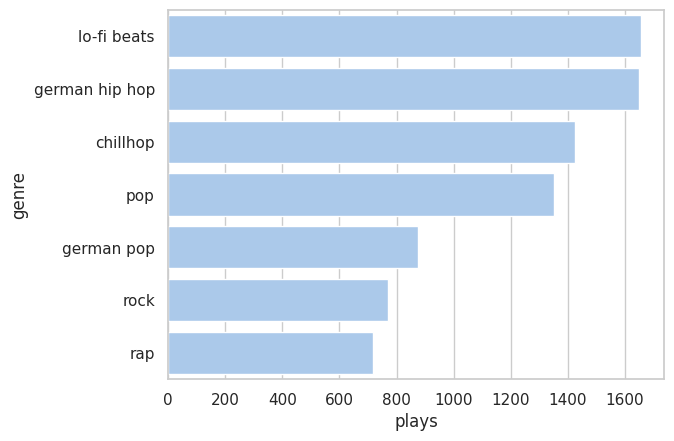

In [7]:
sns.barplot(y=df_plays_n["genre"], x=df_plays_n["plays"])

## 2. Listening behavior of top n genres over time

In [8]:
df_history = pd.read_csv("./processed/ole/history.csv").drop(["Unnamed: 0", "username", "platform", "ip_addr_decrypted", "user_agent_decrypted", "master_metadata_album_artist_name", "master_metadata_album_album_name", "episode_name", "episode_show_name", "spotify_episode_uri", "offline", "offline_timestamp", "incognito_mode"], axis=1).rename({"spotify_track_uri":"track_uri"}, axis=1)
df_history["ts"] = pd.to_datetime(df_history["ts"])
df_history.head(3)

,ts,ms_played,conn_country,master_metadata_track_name,track_uri,reason_start,reason_end,shuffle,skipped
0,2022-09-30 07:27:34+00:00,147252,DE,STFU,spotify:track:7DOq1mhfUI49SNVAlx8E1v,trackdone,trackdone,True,NaN
1,2022-09-30 07:31:17+00:00,223778,DE,Wo bist Du? (feat. Alligatoah),spotify:track:7Dbq3XgIm824Od54EHIhBC,trackdone,trackdone,True,NaN
2,2022-09-30 07:38:50+00:00,412963,DE,What I Know Is All Quicksand - rookery live tapes,spotify:track:71E4QM6O81q0DX79Cg6EGk,trackdone,trackdone,True,NaN


In [9]:
df_history_genre = df_history.merge(df_artist_track, how="left", on="track_uri").merge(df_artist_genre, how="left", on="artist_uri")
df_history_genre.head(3)

,ts,ms_played,conn_country,master_metadata_track_name,track_uri,reason_start,reason_end,shuffle,skipped,artist_uri,genre_id
0,2022-09-30 07:27:34+00:00,147252,DE,STFU,spotify:track:7DOq1mhfUI49SNVAlx8E1v,trackdone,trackdone,True,NaN,spotify:artist:2sis3xwzmvAPHBEOrztf0B,NaN
1,2022-09-30 07:31:17+00:00,223778,DE,Wo bist Du? (feat. Alligatoah),spotify:track:7Dbq3XgIm824Od54EHIhBC,trackdone,trackdone,True,NaN,spotify:artist:702Fgj9mIQ9bzfp9i9Dg7B,NaN
2,2022-09-30 07:31:17+00:00,223778,DE,Wo bist Du? (feat. Alligatoah),spotify:track:7Dbq3XgIm824Od54EHIhBC,trackdone,trackdone,True,NaN,spotify:artist:3d8f0YBZivistZ4Ohauncb,antideutsche


In [13]:
df_genre_timeline = df_history_genre.groupby([df_history_genre["ts"].dt.year, df_history_genre["ts"].dt.month, "genre_id"]).size().to_frame("count")
df_genre_timeline.index.set_names(["year", "month", "genre"], inplace=True)
df_genre_timeline["share"] = df_genre_timeline.groupby(["year", "month"]).transform("sum")
df_genre_timeline["share"] = df_genre_timeline.apply(lambda x: (x["count"]/x["share"]), axis=1)
df_genre_timeline.reset_index(inplace=True)
df_genre_timeline.index.name = "id"

In [14]:
#df_genre_timeline = df_genre_timeline.reset_index()
df_genre_timeline["date"] = pd.to_datetime(df_genre_timeline["year"].astype(str) + "-" + df_genre_timeline["month"].astype(str))
df_genre_timeline = df_genre_timeline.drop(["year", "month"], axis=1)
df_genre_timeline = df_genre_timeline[df_genre_timeline["genre"] != "pop"]

In [15]:
top_genres_per_year = df_genre_timeline.loc[df_genre_timeline.groupby([df_genre_timeline["date"].dt.year])['share'].idxmax()]
top_genres_per_year["year"] = top_genres_per_year["date"].map(lambda x: x.year)
top_genres_per_year.drop(["date"], inplace=True, axis=1)
top_genres_per_year.head(3)

,genre,count,share,year
id,,,,
7,antideutsche,111,0.192374,2015
1254,german hip hop,117,0.130145,2016
3177,writing,61,0.321053,2017


In [16]:
top_n_genres = df_plays_n["genre"].to_numpy()
plot_data = df_genre_timeline[df_genre_timeline["genre"].isin(top_n_genres)]

<Axes: xlabel='date', ylabel='share'>

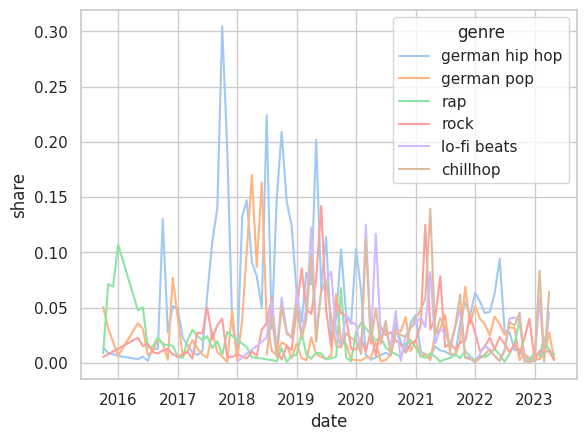

In [17]:
sns.lineplot(data=plot_data, x="date", y="share", hue="genre")

### Genre bump chart

In [18]:
nlargest_per_year = df_genre_timeline.sort_values("count", ascending=False).groupby([df_genre_timeline["date"].dt.year, "genre"])["count"].sum().to_frame().reset_index().sort_values("count", ascending=False).groupby("date").head(5).sort_values("date")
nlargest_per_year["rank"] = nlargest_per_year.groupby("date")["count"].rank(method="min", ascending=False)
nlargest_per_year[nlargest_per_year["date"] == 2015].sort_values("rank")

,date,genre,count,rank
8,2015,antideutsche,114,1.0
121,2015,pop dance,44,2.0
39,2015,dance pop,38,3.0
85,2015,german pop,36,4.0
60,2015,edm,33,5.0


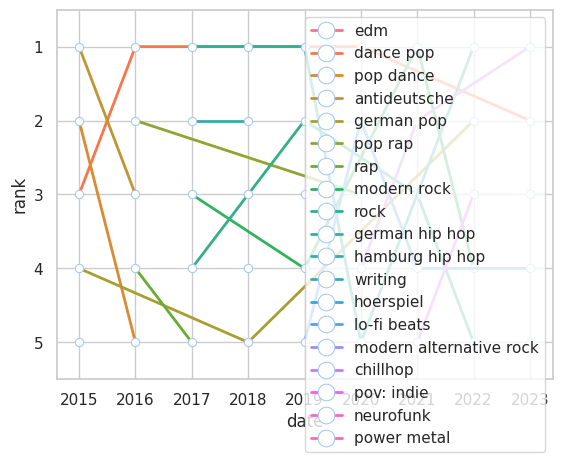

In [19]:
sns.lineplot(x="date", y="rank", data=nlargest_per_year, marker="o", linestyle="-", mfc="w", hue="genre", markersize=6, linewidth=2, markeredgecolor="b")
plt.legend(markerscale=2)
plt.ylim(0.5, 0.5 + 5)
plt.gca().invert_yaxis()
plt.show()